In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


/var/folders/tc/p_2dw00d5zg0svx3_qj__8tc0000gn/T/ipykernel_34827/1070560811.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
file_path = 'diabetes.csv'
df = pd.read_csv(file_path)

display(df.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Remove NaN rows in data

df_no_nan = df.dropna()
df_no_nan.to_csv('diabetes_removed_nan.csv', index=False)

new_df = pd.read_csv("diabetes_removed_nan.csv")

display(new_df.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# Standardize data

features = df.columns
x = new_df.loc[:, features].values

x = StandardScaler().fit_transform(x)

In [5]:
# PCA

pca = PCA()
principalComponents = pca.fit_transform(x)

In [6]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5', 'principal component 6', 'principal component 7', 'principal component 8', 'principal component 9'])

In [7]:
print(pca.explained_variance_ratio_)

[0.26138907 0.19714578 0.12446946 0.09799499 0.09384705 0.08165203
 0.05426927 0.04646457 0.0427678 ]


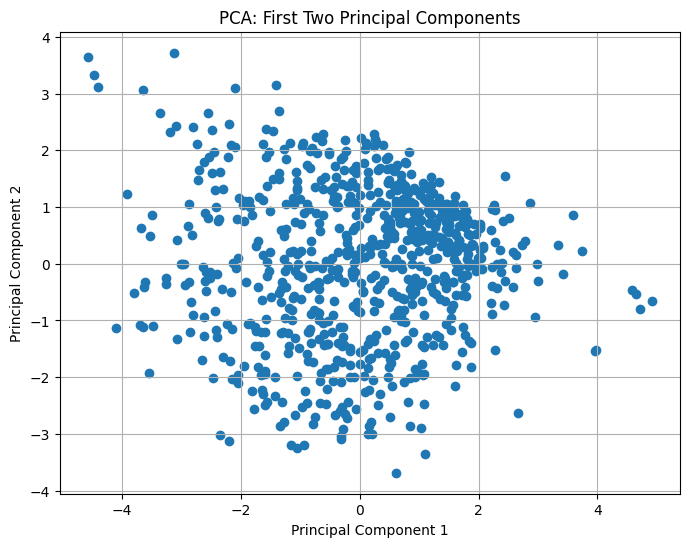

In [8]:
# Plotting 2D
plt.figure(figsize=(8, 6))
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: First Two Principal Components')
plt.grid(True)
plt.show()

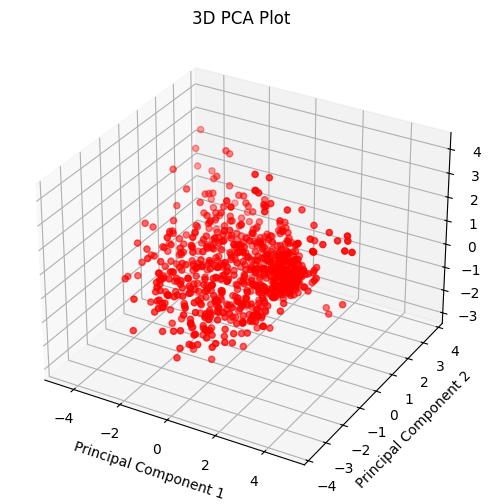

In [9]:
# Plotting 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Extracting the values for each component
x_values = principalDf['principal component 1']
y_values = principalDf['principal component 2']
z_values = principalDf['principal component 3']

# Plotting
ax.scatter(x_values, y_values, z_values, c='r', marker='o')

# Adding labels for each axis
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Title
ax.set_title('3D PCA Plot')

# Show plot
plt.show()